# Interpolation vs Generalization — Experiments (Belkin, Hsu, Mitra 2018)

Objectif :
- Comparer 1-NN (interpolant), k-NN (non-interpolant si k>1), wiNN (interpolant par construction)
- Étudier l'impact :
  - du bruit de labels p_noise
  - du nombre de voisins k
  - du paramètre delta (force de singularité des poids wiNN)
  - de la dimension d

Points importants :
- Avec bruit de labels, interpoler n'implique pas forcément mauvaise généralisation (wiNN peut bien généraliser).
- 1-NN est très local => très sensible au bruit.
- wiNN est interpolant mais reste une moyenne pondérée sur k voisins => peut être robuste.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

# Repro globale (on utilisera aussi des seeds par expérience)
np.random.seed(42)

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 10


In [2]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def accuracy(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    return (y_true == y_pred).mean()

def flip_labels(y, p_noise, rng):
    """
    Symmetric label noise (flip) for binary labels y in {0,1}.
    """
    y = y.copy().astype(int)
    if p_noise <= 0:
        return y
    flips = rng.random(len(y)) < p_noise
    y[flips] = 1 - y[flips]
    return y

def mean_std(arr):
    arr = np.asarray(arr, dtype=float)
    return arr.mean(), arr.std(ddof=1) if len(arr) > 1 else (arr.mean(), 0.0)

def make_logistic_gaussian_data(
    n, d, gamma=2.0, seed=0,
    p_noise=0.0, noisy_labels=True,
    u_mode="sparse"
):
    """
    X ~ N(0, I_d)
    eta(x) = sigmoid(gamma * <u, x>)
    y_clean ~ Bernoulli(eta)
    optional label noise by flipping with prob p_noise.

    Params:
      - noisy_labels: if False, returns clean labels (no flip).
      - u_mode:
          * "sparse": u = e1  (target depends only on x1 => curse of dimensionality for NN distances)
          * "dense" : u random dense normalized (signal spread across dims)
    """
    rng = np.random.default_rng(seed)
    X = rng.normal(0.0, 1.0, size=(n, d))

    if u_mode == "sparse":
        u = np.zeros(d); u[0] = 1.0
    elif u_mode == "dense":
        u = rng.normal(0.0, 1.0, size=d)
        u = u / (np.linalg.norm(u) + 1e-12)
    else:
        raise ValueError("u_mode must be 'sparse' or 'dense'")

    logits = gamma * (X @ u)
    eta = sigmoid(logits)

    y_clean = (rng.random(n) < eta).astype(int)
    if noisy_labels and p_noise > 0:
        y = flip_labels(y_clean, p_noise, rng)
    else:
        y = y_clean

    return X, y, y_clean
def make_2d_dataset(kind="moons", n=900, noise=0.25, p_noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    if kind == "moons":
        X, y_clean = make_moons(n_samples=n, noise=noise, random_state=seed)
    elif kind == "circles":
        X, y_clean = make_circles(n_samples=n, noise=noise, factor=0.5, random_state=seed)
    else:
        raise ValueError("kind must be 'moons' or 'circles'")

    y_clean = y_clean.astype(int)
    y = flip_labels(y_clean, p_noise, rng) if p_noise > 0 else y_clean.copy()
    return X, y, y_clean



In [14]:
class KNNClassifier:
    """
    Simple k-NN classifier with probability estimate = mean label among neighbors.
    """
    def __init__(self, k=1):
        self.k = int(k)
        self.nn = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k, algorithm="auto")
        self.nn.fit(self.X_train)
        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        _, idxs = self.nn.kneighbors(X, return_distance=True)
        y_neighbors = self.y_train[idxs]  # (n_test, k)
        proba1 = y_neighbors.mean(axis=1)
        proba0 = 1.0 - proba1
        return np.vstack([proba0, proba1]).T

    def predict(self, X):
        proba1 = self.predict_proba(X)[:, 1]
        return (proba1 >= 0.5).astype(int)
    
class WiNNClassifier:
    """
    weighted interpolated k-NN (wiNN), with weights:
        w_i(x) = phi( ||x - x^(i)|| / ||x - x^(k+1)|| )
    typically phi(t) = t^{-delta} (singular at 0).

    IMPORTANT: to guarantee interpolation robustly, we explicitly force:
        if nearest neighbor distance == 0  => prediction = its label.
    This avoids numerical issues for very small delta or eps clipping.
    """
    def __init__(self, k=50, delta=1.0, eps=1e-12):
        self.k = int(k)
        self.delta = float(delta)
        self.eps = float(eps)
        self.nn = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k + 1, algorithm="auto")
        self.nn.fit(self.X_train)
        return self

    def predict_proba(self, X):
        X = np.asarray(X)

        dists_all, idxs_all = self.nn.kneighbors(X, return_distance=True)
        dists_k = dists_all[:, :self.k]      # (n_test, k)
        idxs_k  = idxs_all[:, :self.k]
        r = dists_all[:, self.k]             # (n_test,) (k+1)-th distance

        y_neighbors = self.y_train[idxs_k]   # (n_test, k)

        # --- Interpolation safeguard ---
        # If the nearest neighbor is exactly a training point, force prediction = that label
        zero_nn = (dists_k[:, 0] < 1e-12)


        # Normalized distances
        r_safe = np.maximum(r, self.eps)
        t = dists_k / r_safe[:, None]
        t = np.maximum(t, self.eps)

        # weights = t^{-delta}
        w = t ** (-self.delta)

        num = (w * y_neighbors).sum(axis=1)
        den = w.sum(axis=1)
        proba1 = num / np.maximum(den, self.eps)

        # Force exact match on training points (interpolation)
        proba1[zero_nn] = y_neighbors[zero_nn, 0]

        proba0 = 1.0 - proba1
        return np.vstack([proba0, proba1]).T

    def predict(self, X):
        proba1 = self.predict_proba(X)[:, 1]
        return (proba1 >= 0.5).astype(int)



In [4]:
def eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)
    return {
        "train_err": 1.0 - accuracy(y_train, yhat_tr),
        "test_err":  1.0 - accuracy(y_test,  yhat_te),
    }

def make_train_test_logistic(
    n_train=3000, n_test=8000, d=20, gamma=2.0,
    p_noise=0.2, seed=0,
    train_noisy=True, test_noisy=False,
    u_mode="sparse"
):
    """
    Recommended default: train_noisy=True, test_noisy=False
    => you learn from noisy labels but evaluate on clean truth (more meaningful).
    """
    Xtr, ytr, ytr_clean = make_logistic_gaussian_data(
        n_train, d, gamma=gamma, seed=seed+1, p_noise=p_noise, noisy_labels=train_noisy, u_mode=u_mode
    )
    Xte, yte, yte_clean = make_logistic_gaussian_data(
        n_test,  d, gamma=gamma, seed=seed+2, p_noise=p_noise, noisy_labels=test_noisy,  u_mode=u_mode
    )

    # If test is clean, use yte_clean as ground truth
    y_test = yte if test_noisy else yte_clean
    return Xtr, ytr, Xte, y_test


## Sanity check: interpolation property

On vérifie :
- 1-NN : train error = 0 (toujours)
- wiNN : train error = 0 (grâce au correctif "zero distance => label exact")
- k-NN (k>1) : train error > 0 en présence de bruit


In [5]:
Xtr, ytr, Xte, yte = make_train_test_logistic(
    n_train=2000, n_test=5000, d=20, gamma=2.0,
    p_noise=0.2, seed=0,
    train_noisy=True, test_noisy=False,  # recommended
    u_mode="sparse"
)

models = {
    "1-NN": KNNClassifier(k=1),
    "k-NN (k=25)": KNNClassifier(k=25),
    "wiNN (k=25, delta=0.1)": WiNNClassifier(k=25, delta=0.1),
    "wiNN (k=25, delta=1.0)": WiNNClassifier(k=25, delta=1.0),
}

for name, m in models.items():
    res = eval_model(m, Xtr, ytr, Xte, yte)
    print(f"{name:22s}  train_err={res['train_err']:.4f}  test_err={res['test_err']:.4f}")


1-NN                    train_err=0.0000  test_err=0.4210
k-NN (k=25)             train_err=0.3330  test_err=0.3236
wiNN (k=25, delta=0.1)  train_err=0.0365  test_err=0.3236
wiNN (k=25, delta=1.0)  train_err=0.0000  test_err=0.3228


In [6]:
def plot_2d_decision_boundary(model, X_train, y_train, title="", grid_step=0.03):
    """
    Fit model and plot P(y=1) over a grid + training points.
    """
    model.fit(X_train, y_train)

    x_min, x_max = X_train[:, 0].min() - 0.8, X_train[:, 0].max() + 0.8
    y_min, y_max = X_train[:, 1].min() - 0.8, X_train[:, 1].max() + 0.8

    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    grid = np.c_[xx.ravel(), yy.ravel()]

    proba = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    plt.figure(figsize=(6, 4))
    plt.contourf(xx, yy, proba, levels=30)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=12, edgecolors="k", linewidths=0.2)
    plt.colorbar(label="P(y=1)")
    plt.title(title)
    plt.tight_layout()


1-NN                train_err=0.0000  test_err=0.3417
k-NN k=25           train_err=0.2426  test_err=0.2444
wiNN k=25 delta=1.0  train_err=0.0000  test_err=0.2583


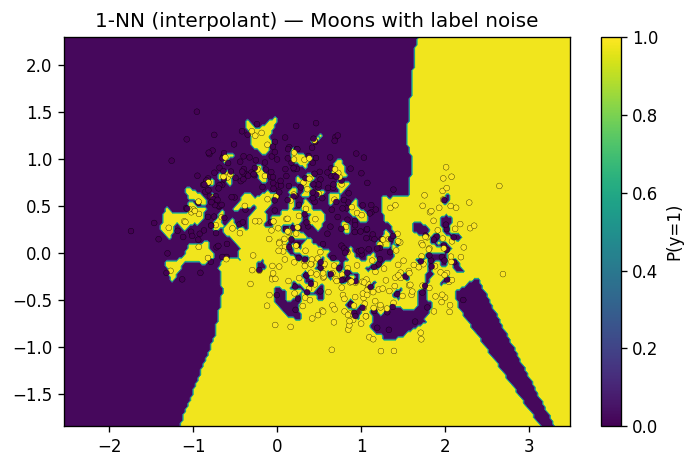

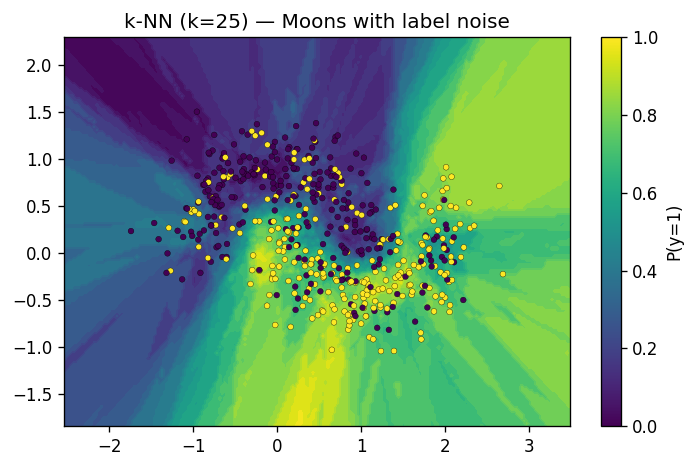

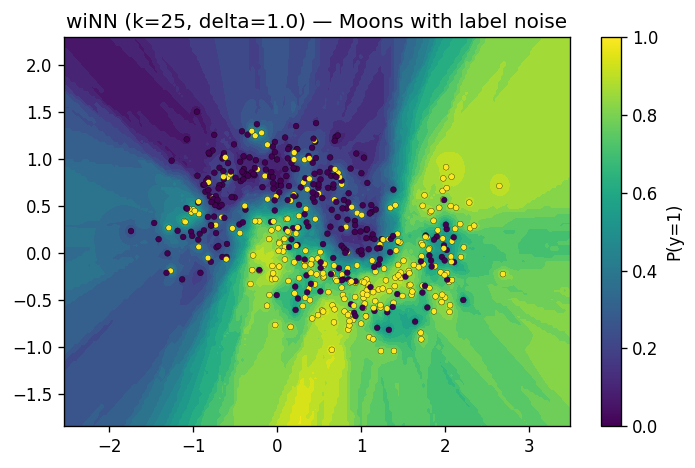

In [7]:
X2, y2, y2_clean = make_2d_dataset(kind="moons", n=900, noise=0.25, p_noise=0.2, seed=2)
Xtr2, Xte2, ytr2, yte2 = train_test_split(X2, y2, test_size=0.4, random_state=0)

plot_2d_decision_boundary(KNNClassifier(k=1), Xtr2, ytr2, "1-NN (interpolant) — Moons with label noise")
plot_2d_decision_boundary(KNNClassifier(k=25), Xtr2, ytr2, "k-NN (k=25) — Moons with label noise")
plot_2d_decision_boundary(WiNNClassifier(k=25, delta=1.0), Xtr2, ytr2, "wiNN (k=25, delta=1.0) — Moons with label noise")

for name, m in [("1-NN", KNNClassifier(1)),
                ("k-NN k=25", KNNClassifier(25)),
                ("wiNN k=25 delta=1.0", WiNNClassifier(25, 1.0))]:
    res = eval_model(m, Xtr2, ytr2, Xte2, yte2)
    print(f"{name:18s}  train_err={res['train_err']:.4f}  test_err={res['test_err']:.4f}")


In [8]:
def run_many_seeds(
    make_data_fn,
    model_fns,
    seeds,
):
    """
    make_data_fn(seed) -> (Xtr, ytr, Xte, yte)
    model_fns: dict name -> function() that returns a fresh model

    Returns: dict name -> {"train_err": [..], "test_err":[..]}
    """
    out = {name: {"train_err": [], "test_err": []} for name in model_fns}

    for s in seeds:
        Xtr, ytr, Xte, yte = make_data_fn(s)
        for name, mf in model_fns.items():
            model = mf()
            res = eval_model(model, Xtr, ytr, Xte, yte)
            out[name]["train_err"].append(res["train_err"])
            out[name]["test_err"].append(res["test_err"])

    # Convert to arrays
    for name in out:
        out[name]["train_err"] = np.array(out[name]["train_err"], dtype=float)
        out[name]["test_err"]  = np.array(out[name]["test_err"], dtype=float)

    return out

def plot_mean_std_curve(x, y_means, y_stds, xlabel, ylabel, title, labels, xscale=None):
    plt.figure(figsize=(6.5, 4))
    for mean, std, lab in zip(y_means, y_stds, labels):
        plt.plot(x, mean, marker="o", label=lab)
        plt.fill_between(x, mean-std, mean+std, alpha=0.15)
    if xscale:
        plt.xscale(xscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


## Expérience 1 — Test error vs k (fixed d, fixed noise)

But :
- Montrer que 1-NN (interpolant) est fragile au bruit
- Montrer que k-NN améliore la robustesse quand k augmente
- Montrer que wiNN (interpolant) suit souvent k-NN si delta est modéré

On trace aussi la train error :
- 1-NN et wiNN devraient avoir train error ~ 0
- k-NN (k>1) garde une train error non nulle sous bruit


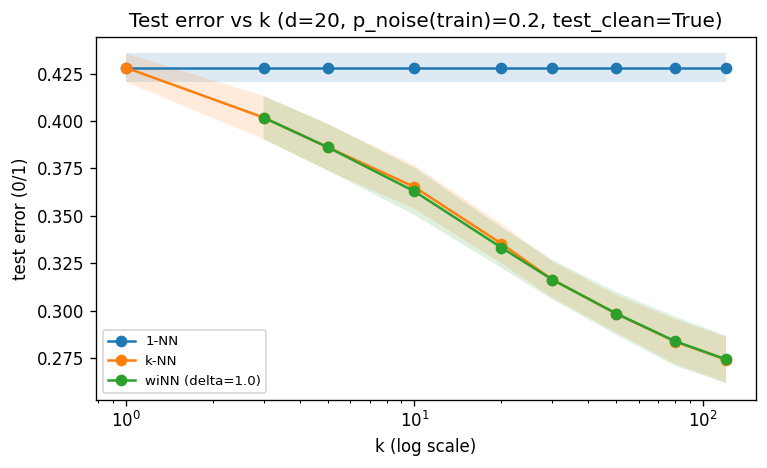

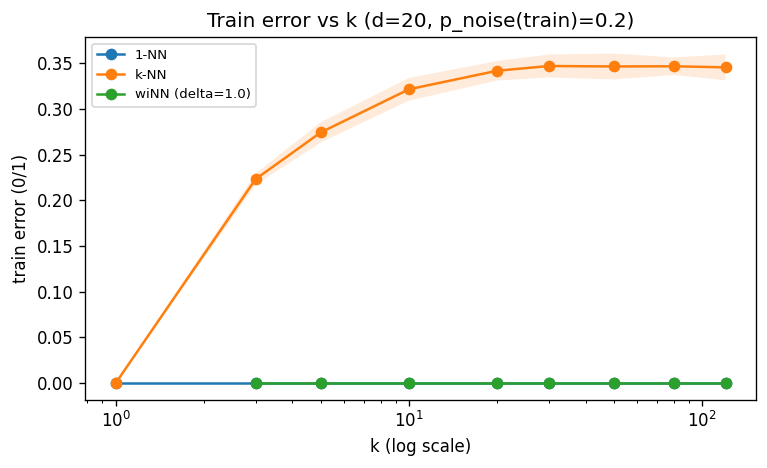

In [9]:
d = 20
gamma = 2.0
p_noise = 0.2
u_mode = "sparse"          # pour voir l'effet "dimensions inutiles"
train_noisy = True
test_noisy  = False        # test propre (recommandé)

seeds = list(range(10))    # augmente à 20 si tu veux plus stable

k_values = [1, 3, 5, 10, 20, 30, 50, 80, 120]
delta_fixed = 1.0

test_means, test_stds = [], []
train_means, train_stds = [], []

for k in k_values:
    def make_data(seed):
        return make_train_test_logistic(
            n_train=2500, n_test=8000, d=d, gamma=gamma,
            p_noise=p_noise, seed=seed,
            train_noisy=train_noisy, test_noisy=test_noisy,
            u_mode=u_mode
        )

    model_fns = {
        "1-NN": (lambda: KNNClassifier(k=1)),
        f"k-NN (k={k})": (lambda k=k: KNNClassifier(k=k)),
    }
    if k >= 2:
        model_fns[f"wiNN (k={k}, delta={delta_fixed})"] = (lambda k=k: WiNNClassifier(k=k, delta=delta_fixed))

    res = run_many_seeds(make_data, model_fns, seeds)

    # Collect only for the variable-k curves:
    # For plotting, we want k-NN and wiNN curves, plus 1-NN constant.
    # We'll store 3 arrays aligned with k_values for means/stds.

# Re-run but collect arrays for 3 curves explicitly
curve_names = ["1-NN", "k-NN", "wiNN"]
test_curve = {cn: [] for cn in curve_names}
test_std   = {cn: [] for cn in curve_names}
train_curve= {cn: [] for cn in curve_names}
train_std_ = {cn: [] for cn in curve_names}

for k in k_values:
    def make_data(seed):
        return make_train_test_logistic(
            n_train=2500, n_test=8000, d=d, gamma=gamma,
            p_noise=p_noise, seed=seed,
            train_noisy=train_noisy, test_noisy=test_noisy,
            u_mode=u_mode
        )

    model_fns = {
        "1-NN": (lambda: KNNClassifier(k=1)),
        "k-NN": (lambda k=k: KNNClassifier(k=k)),
    }
    if k >= 2:
        model_fns["wiNN"] = (lambda k=k: WiNNClassifier(k=k, delta=delta_fixed))
    else:
        # for k=1, wiNN not defined with k+1 neighbors; set to NaN
        model_fns["wiNN"] = None

    # Run
    out = {cn: {"train_err": np.array([np.nan]*len(seeds)), "test_err": np.array([np.nan]*len(seeds))} for cn in curve_names}
    res = run_many_seeds(make_data, {k_: v for k_, v in model_fns.items() if v is not None}, seeds)

    # Fill results
    for cn in ["1-NN", "k-NN"]:
        m, s = mean_std(res[cn]["test_err"])
        test_curve[cn].append(m); test_std[cn].append(s)
        m, s = mean_std(res[cn]["train_err"])
        train_curve[cn].append(m); train_std_[cn].append(s)

    if model_fns["wiNN"] is None:
        test_curve["wiNN"].append(np.nan); test_std["wiNN"].append(np.nan)
        train_curve["wiNN"].append(np.nan); train_std_["wiNN"].append(np.nan)
    else:
        m, s = mean_std(res["wiNN"]["test_err"])
        test_curve["wiNN"].append(m); test_std["wiNN"].append(s)
        m, s = mean_std(res["wiNN"]["train_err"])
        train_curve["wiNN"].append(m); train_std_["wiNN"].append(s)

# Plot test error vs k
plot_mean_std_curve(
    x=np.array(k_values),
    y_means=[np.array(test_curve["1-NN"]), np.array(test_curve["k-NN"]), np.array(test_curve["wiNN"])],
    y_stds =[np.array(test_std["1-NN"]),   np.array(test_std["k-NN"]),   np.array(test_std["wiNN"])],
    xlabel="k (log scale)",
    ylabel="test error (0/1)",
    title=f"Test error vs k (d={d}, p_noise(train)={p_noise}, test_clean={not test_noisy})",
    labels=["1-NN", "k-NN", f"wiNN (delta={delta_fixed})"],
    xscale="log"
)

# Plot train error vs k
plot_mean_std_curve(
    x=np.array(k_values),
    y_means=[np.array(train_curve["1-NN"]), np.array(train_curve["k-NN"]), np.array(train_curve["wiNN"])],
    y_stds =[np.array(train_std_["1-NN"]),  np.array(train_std_["k-NN"]),  np.array(train_std_["wiNN"])],
    xlabel="k (log scale)",
    ylabel="train error (0/1)",
    title=f"Train error vs k (d={d}, p_noise(train)={p_noise})",
    labels=["1-NN", "k-NN", f"wiNN (delta={delta_fixed})"],
    xscale="log"
)


## Expérience 2 — Robustesse au bruit (fixed d, fixed k)

But :
- Montrer que 1-NN (interpolant) se dégrade vite quand p_noise augmente.
- Montrer que k-NN et wiNN (k fixe) sont plus robustes.
- Mettre en évidence que wiNN peut rester proche de k-NN si delta est modéré.


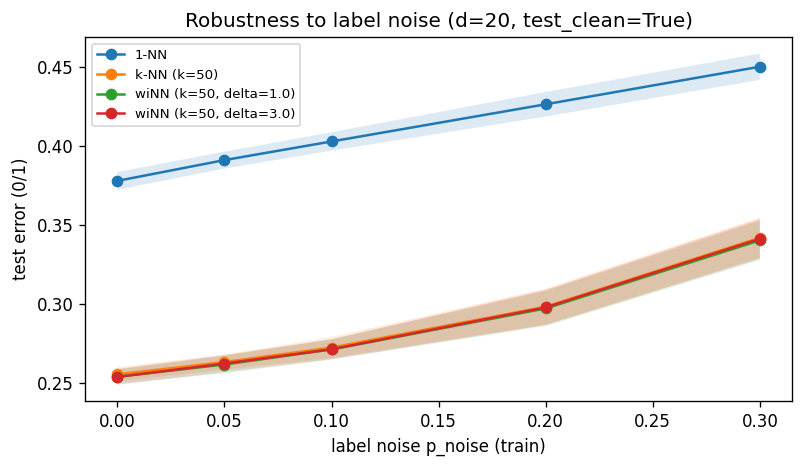

p_noise | 1-NN | k-NN | wiNN(delta=1.0) | wiNN(delta=3.0)
0.00   | 0.3778 | 0.2556 | 0.2541        | 0.2540
0.05   | 0.3909 | 0.2634 | 0.2618        | 0.2625
0.10   | 0.4027 | 0.2726 | 0.2714        | 0.2715
0.20   | 0.4262 | 0.2983 | 0.2972        | 0.2979
0.30   | 0.4499 | 0.3419 | 0.3402        | 0.3412


In [ ]:
d = 20
k_fixed = 50
gamma = 2.0
u_mode = "sparse"
train_noisy = True
test_noisy  = False  # test clean

noise_grid = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = list(range(20))

# Compare two deltas for wiNN: moderate vs more local
delta_list = [1.0, 3.0]

means_1nn, std_1nn = [], []
means_knn, std_knn = [], []

means_winn = {delta: [] for delta in delta_list}
std_winn   = {delta: [] for delta in delta_list}

for p_noise in noise_grid:

    def make_data(seed):
        return make_train_test_logistic(
            n_train=2500, n_test=8000, d=d, gamma=gamma,
            p_noise=p_noise, seed=seed,
            train_noisy=train_noisy, test_noisy=test_noisy,
            u_mode=u_mode
        )

    model_fns = {
        "1-NN": (lambda: KNNClassifier(k=1)),
        "k-NN": (lambda: KNNClassifier(k=k_fixed)),
    }
    for delta in delta_list:
        model_fns[f"wiNN(delta={delta})"] = (lambda delta=delta: WiNNClassifier(k=k_fixed, delta=delta))

    res = run_many_seeds(make_data, model_fns, seeds)

    m, s = mean_std(res["1-NN"]["test_err"]); means_1nn.append(m); std_1nn.append(s)
    m, s = mean_std(res["k-NN"]["test_err"]); means_knn.append(m); std_knn.append(s)

    for delta in delta_list:
        key = f"wiNN(delta={delta})"
        m, s = mean_std(res[key]["test_err"])
        means_winn[delta].append(m)
        std_winn[delta].append(s)

plt.figure(figsize=(6.8, 4))

plt.plot(noise_grid, means_1nn, marker="o", label="1-NN")
plt.fill_between(
    noise_grid,
    np.array(means_1nn) - np.array(std_1nn),
    np.array(means_1nn) + np.array(std_1nn),
    alpha=0.15
)

plt.plot(noise_grid, means_knn, marker="o", label=f"k-NN (k={k_fixed})")
plt.fill_between(
    noise_grid,
    np.array(means_knn) - np.array(std_knn),
    np.array(means_knn) + np.array(std_knn),
    alpha=0.15
)

for delta in delta_list:
    plt.plot(noise_grid, means_winn[delta], marker="o", label=f"wiNN (k={k_fixed}, delta={delta})")
    plt.fill_between(
        noise_grid,
        np.array(means_winn[delta]) - np.array(std_winn[delta]),
        np.array(means_winn[delta]) + np.array(std_winn[delta]),
        alpha=0.15
    )

plt.xlabel("label noise p_noise (train)")
plt.ylabel("test error (0/1)")
plt.title(f"Robustness to label noise (d={d}, test_clean={not test_noisy})")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

print("p_noise | 1-NN | k-NN | wiNN(delta=1.0) | wiNN(delta=3.0)")
for i, p in enumerate(noise_grid):
    row = [
        p,
        means_1nn[i],
        means_knn[i],
        means_winn[1.0][i],
        means_winn[3.0][i],
    ]
    print(f"{row[0]:.2f}   | {row[1]:.4f} | {row[2]:.4f} | {row[3]:.4f}        | {row[4]:.4f}")


## Expérience 3 — Test error vs delta (fixed d, fixed k)

But :
- delta contrôle la force de singularité des poids wiNN.
- delta grand => comportement plus proche de 1-NN (plus local, plus sensible au bruit)
- delta petit => plus proche d'un k-NN lissé

Important :
- On moyenne sur plusieurs seeds car l'effet peut être subtil.
- On vérifie aussi que train error reste ~0 (interpolation).


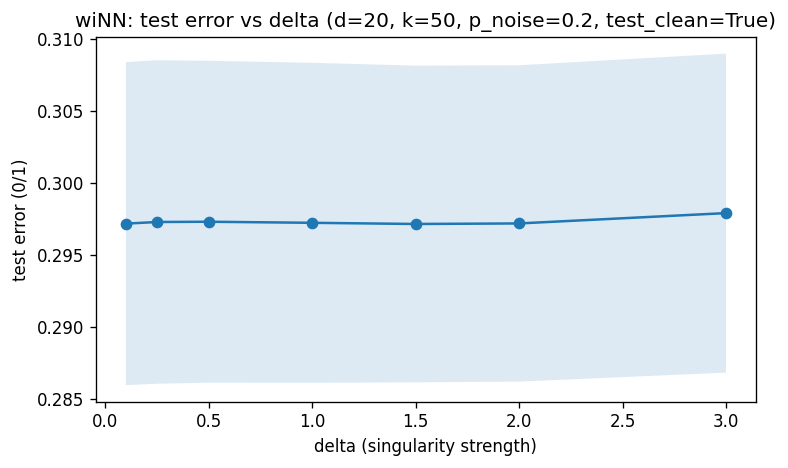

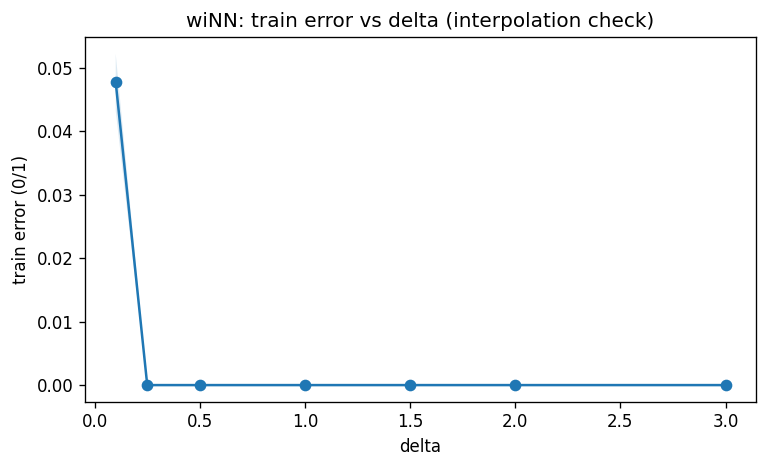

In [15]:
d = 20
k_fixed = 50
gamma = 2.0
p_noise = 0.2
u_mode = "sparse"
train_noisy = True
test_noisy  = False

delta_grid = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 3.0]
seeds = list(range(20))

test_mean, test_std = [], []
train_mean, train_std = [], []

for delta in delta_grid:
    def make_data(seed):
        return make_train_test_logistic(
            n_train=2500, n_test=8000, d=d, gamma=gamma,
            p_noise=p_noise, seed=seed,
            train_noisy=train_noisy, test_noisy=test_noisy,
            u_mode=u_mode
        )

    model_fns = {
        "wiNN": (lambda delta=delta: WiNNClassifier(k=k_fixed, delta=delta)),
    }
    res = run_many_seeds(make_data, model_fns, seeds)

    m, s = mean_std(res["wiNN"]["test_err"]);  test_mean.append(m);  test_std.append(s)
    m, s = mean_std(res["wiNN"]["train_err"]); train_mean.append(m); train_std.append(s)

# Plot test
plt.figure(figsize=(6.5, 4))
plt.plot(delta_grid, test_mean, marker="o")
plt.fill_between(delta_grid, np.array(test_mean)-np.array(test_std), np.array(test_mean)+np.array(test_std), alpha=0.15)
plt.xlabel("delta (singularity strength)")
plt.ylabel("test error (0/1)")
plt.title(f"wiNN: test error vs delta (d={d}, k={k_fixed}, p_noise={p_noise}, test_clean={not test_noisy})")
plt.tight_layout()
plt.show()

# Plot train (should be ~0)
plt.figure(figsize=(6.5, 4))
plt.plot(delta_grid, train_mean, marker="o")
plt.fill_between(delta_grid, np.array(train_mean)-np.array(train_std), np.array(train_mean)+np.array(train_std), alpha=0.15)
plt.xlabel("delta")
plt.ylabel("train error (0/1)")
plt.title("wiNN: train error vs delta (interpolation check)")
plt.tight_layout()
plt.show()


## Expérience 4 — Test error vs dimension d

Attention : la dimension d peut avoir deux effets opposés selon le "teacher".

- Teacher sparse (u = e1) :
  la vraie règle dépend d'une seule coordonnée (x1), mais la distance NN est en dD.
  => quand d augmente, les dimensions inutiles dominent la distance
  => les voisins deviennent moins informatifs (curse of dimensionality).

- Teacher dense (u aléatoire dense) :
  le signal est "réparti" sur les dimensions.
  => les distances peuvent rester plus corrélées au label, donc l'effet négatif est réduit.

On trace les deux pour expliquer clairement tes observations dans le rapport.


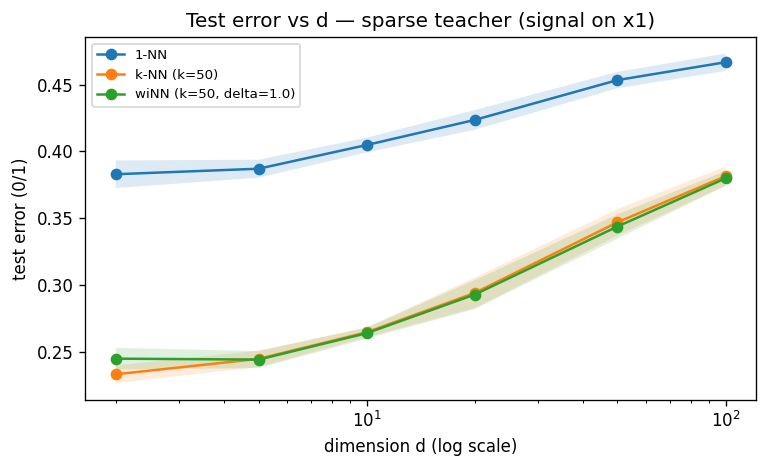

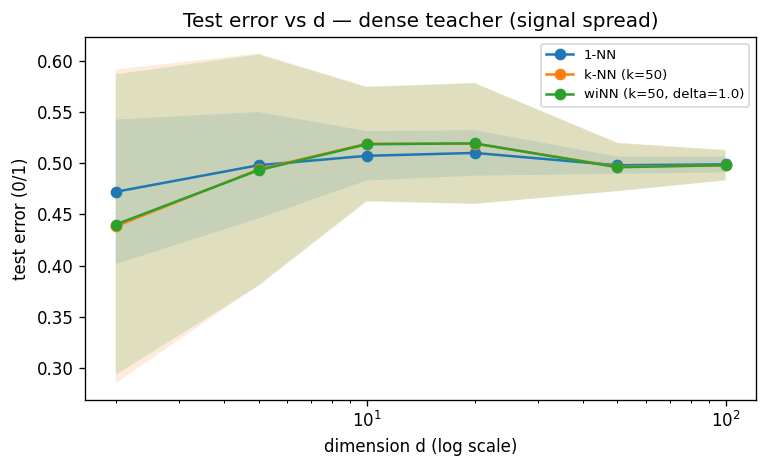

In [12]:
dims = [2, 5, 10, 20, 50, 100]
gamma = 2.0
p_noise = 0.2
k_fixed = 50
delta_fixed = 1.0
seeds = list(range(15))

def run_vs_d(u_mode):
    mean_1nn, std_1nn = [], []
    mean_knn, std_knn = [], []
    mean_winn, std_winn = [], []

    for d in dims:
        def make_data(seed):
            return make_train_test_logistic(
                n_train=3000, n_test=9000, d=d, gamma=gamma,
                p_noise=p_noise, seed=seed,
                train_noisy=True, test_noisy=False,
                u_mode=u_mode
            )

        model_fns = {
            "1-NN": (lambda: KNNClassifier(k=1)),
            "k-NN": (lambda: KNNClassifier(k=k_fixed)),
            "wiNN": (lambda: WiNNClassifier(k=k_fixed, delta=delta_fixed)),
        }
        res = run_many_seeds(make_data, model_fns, seeds)

        m, s = mean_std(res["1-NN"]["test_err"]); mean_1nn.append(m); std_1nn.append(s)
        m, s = mean_std(res["k-NN"]["test_err"]); mean_knn.append(m); std_knn.append(s)
        m, s = mean_std(res["wiNN"]["test_err"]); mean_winn.append(m); std_winn.append(s)

    return (np.array(mean_1nn), np.array(std_1nn),
            np.array(mean_knn), np.array(std_knn),
            np.array(mean_winn), np.array(std_winn))

# sparse teacher
m1_s, s1_s, mk_s, sk_s, mw_s, sw_s = run_vs_d("sparse")

plt.figure(figsize=(6.5, 4))
plt.plot(dims, m1_s, marker="o", label="1-NN")
plt.fill_between(dims, m1_s-s1_s, m1_s+s1_s, alpha=0.15)
plt.plot(dims, mk_s, marker="o", label=f"k-NN (k={k_fixed})")
plt.fill_between(dims, mk_s-sk_s, mk_s+sk_s, alpha=0.15)
plt.plot(dims, mw_s, marker="o", label=f"wiNN (k={k_fixed}, delta={delta_fixed})")
plt.fill_between(dims, mw_s-sw_s, mw_s+sw_s, alpha=0.15)
plt.xscale("log")
plt.xlabel("dimension d (log scale)")
plt.ylabel("test error (0/1)")
plt.title("Test error vs d — sparse teacher (signal on x1)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# dense teacher
m1_d, s1_d, mk_d, sk_d, mw_d, sw_d = run_vs_d("dense")

plt.figure(figsize=(6.5, 4))
plt.plot(dims, m1_d, marker="o", label="1-NN")
plt.fill_between(dims, m1_d-s1_d, m1_d+s1_d, alpha=0.15)
plt.plot(dims, mk_d, marker="o", label=f"k-NN (k={k_fixed})")
plt.fill_between(dims, mk_d-sk_d, mk_d+sk_d, alpha=0.15)
plt.plot(dims, mw_d, marker="o", label=f"wiNN (k={k_fixed}, delta={delta_fixed})")
plt.fill_between(dims, mw_d-sw_d, mw_d+sw_d, alpha=0.15)
plt.xscale("log")
plt.xlabel("dimension d (log scale)")
plt.ylabel("test error (0/1)")
plt.title("Test error vs d — dense teacher (signal spread)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()
